## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [6]:
path = Path('planet')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('planet')

In [7]:
path

PosixPath('planet')

In [7]:
# Unzip datasets
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [7]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [13]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

here each Image can have multiple labels. The 'planet/train_v2.csv'file containing the labels we see that each 'image_name' is associated to several tags separated by spaces.

In [8]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [10]:
path

PosixPath('/home/skumar/.fastai/data/planet')

In [12]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [13]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [19]:
from tqdm.notebook import tqdm
lst = []

for i in tqdm(range(len(data.train_ds))):
    labels = str(data.train_ds[i][1]).split(';')
    lst.extend(labels)

set(lst)    

{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

In [17]:
str(data.train_ds[1][1])

'clear;primary'

`show_batch` still works, and show us the different labels separated by `;`.

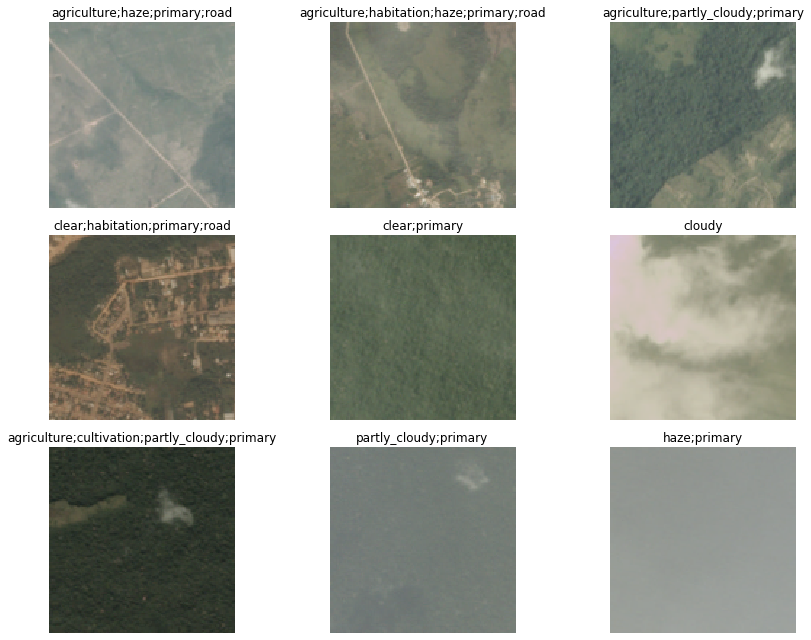

In [27]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [30]:
accuracy_thresh??

In [33]:
arch = models.resnet50

In [1]:
acc_02

NameError: name 'acc_02' is not defined

In [34]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


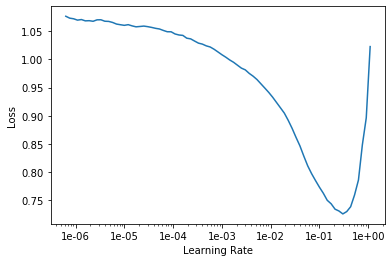

In [36]:
learn.recorder.plot()

Then we can fit the head of our network.

In [37]:
lr = 0.01

In [43]:
learn.fit_one_cycle?

In [38]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.133866,0.112550,0.948101,0.902924,06:47
1,0.107320,0.099688,0.955441,0.914089,01:41
2,0.098880,0.090975,0.957018,0.922234,01:41
3,0.092885,0.088278,0.955172,0.924335,01:42


In [44]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [39]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


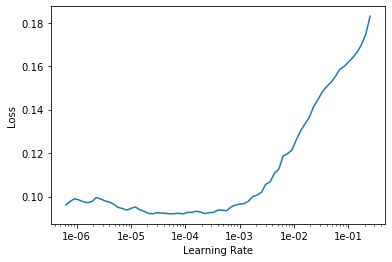

In [40]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, slice(1e-5, 1e-04))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.107826,0.094413,0.952760,0.916122,06:24
1,0.103481,0.091014,0.954664,0.921181,06:17
2,0.099292,0.090101,0.955085,0.922122,06:13
3,0.099089,0.089791,0.956611,0.922069,06:10
4,0.097972,0.089435,0.955615,0.922412,06:17


In [48]:
learn.save('stage-2-rn50')

In [70]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
data.batch_size = 30
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [46]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


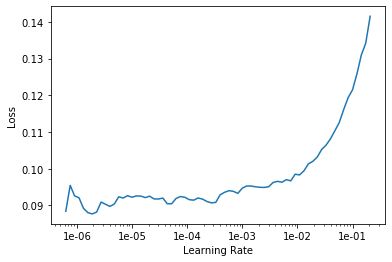

In [47]:
learn.lr_find()
learn.recorder.plot()

In [68]:
lr=1e-2/2

In [71]:
learn.fit_one_cycle(5, 1.1e-04,lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086450,0.084866,0.958442,0.927094,06:22
1,0.078920,0.083003,0.959917,0.928001,06:08
2,0.084346,0.082829,0.959488,0.929076,06:08
3,0.080903,0.082124,0.959270,0.929806,06:08
4,0.082476,0.082216,0.960695,0.929906,06:10


In [29]:
learn.save('stage-1-256-rn50')

In [49]:
learn.load('stage-1-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/skumar/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/skumar/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=

In [23]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.072655,0.085904,0.958871,0.927597,02:27
1,0.079723,0.085476,0.956589,0.926462,02:26
2,0.075861,0.085859,0.959539,0.926974,02:26
3,0.069405,0.086530,0.959954,0.927474,02:25
4,0.066098,0.087354,0.959764,0.927764,02:23


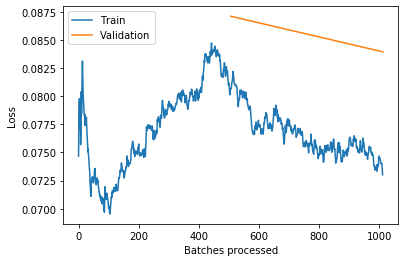

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [50]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/skumar/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/skumar/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=

In [76]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [55]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [74]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efbd320bae8>
Traceback (most recent call last):
  File "/home/skumar/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/skumar/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/skumar/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/skumar/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/skumar/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


61191

In [73]:
test

ImageList (61191 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/skumar/.fastai/data/planet/test-jpg

In [77]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [78]:
thresh = 0.25
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [79]:
labelled_preds[:5]

['agriculture clear habitation primary road',
 'clear primary',
 'agriculture clear cultivation primary road',
 'agriculture clear cultivation primary road',
 'agriculture partly_cloudy primary road']

In [80]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [81]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [82]:
df.to_csv(path/'submission.csv', index=False)

In [67]:
kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission.csv -m "Message"

/bin/sh: 1: home/.kaggle/kaggle: not found


Private Leaderboard score: 0.9296 (around 80th)